In [1]:
import numpy as np
from shapely import Polygon, LineString
from shapely.ops import unary_union
import utm
import ast

In [2]:
def from_latlon(latitude, longitude, geozone_num, geozone_let):
    """
    convert lat, lon to (x, y) coordinates (in meters)
    :param latitude:  list or np.array (shape: (n,))
    :param longitude: list or np.array (shape: (n,))
    :param geozone_num: geozone integer
    :param geozone_let: geozone letter
    :return: np.array of (x, y) coordinates (shape: (n, 2))
    """
    xy = np.array([
        utm.from_latlon(
            latitude=lat, 
            longitude=lon, 
            force_zone_number=geozone_num,
            force_zone_letter=geozone_let
        )[:2] for lat, lon in zip(latitude, longitude)
    ])
    return xy



def get_subfields_xy(field_bounds: list, geozone_num, geozone_let):
    """
    convert GPS bounds of field into (x, y) coordinates (in meters)
    :param field_bounds: list with GPS bounds of subfields
    :return: list of (x, y) bounds of the subfields
    """
    subfields = [np.array(subfield).T for subfield in field_bounds]
    bounds_xy = [from_latlon(field[1], field[0], geozone_num, geozone_let) for field in subfields]
    return bounds_xy



def get_bounds_from_string(field_bounds_str : str):
    """
    convert string representation of the bounds into list
    :param field_bounds_str: string representation of the bounds
    :return: list of bounds of the subfields
    """
    if field_bounds_str[:4] == '[[[[':
        field_bounds_str = field_bounds_str.replace('[[[', '[[').replace(']]]', ']]')
    field_bounds = ast.literal_eval(field_bounds_str) 
    return field_bounds



def get_geozone(latitude, longitude):
    """
    :param latitude: 
    :param longitude: 
    :return: UTM geozone number and letter
    """
    geozone_num, geozone_let = utm.from_latlon(latitude, longitude)[2:]
    return geozone_num, geozone_let

In [3]:
def get_area_and_distance(
    tool_width : float,
    time : list,
    track_lat : list,
    track_lon : list,
    path_distance : list,
    field_processed : list,
    field_bounds : list
):
    """
    calculate path distance and processed field area
    :param tool_width: width of the tool (in meters)
    :param track_lat: list or np.array (shape: (n,))
    :param track_lon: list or np.array (shape: (n,))
    :param path_distance: list of pre-calculated path distances (shape: (m,))
    :param field_processed: list of pre-calculated processed area (shape: (m,))
    :param field_bounds: list of GPS subfields bounds
    :return: dictionary with calculated processed area and path distance
    """
    # get working UTM zone number and letter
    geozone_num, geozone_let = get_geozone(track_lat[0], track_lon[0])
    
    # convert GPS coordinates of the track
    track_xy = from_latlon(track_lat, track_lon, geozone_num, geozone_let)
    
    # convert GPS coordinates of the field bounds and create field polygon
    subfields_xy = get_subfields_xy(field_bounds, geozone_num, geozone_let)
    field_polygon = unary_union([
        Polygon(subfield).buffer(0) if len(subfield) > 1 else None for subfield in subfields_xy
    ])
    
    # calculate distance and area and add them to the lists
    for i in range(len(field_processed), len(time)):
        track = LineString(track_xy[:i])
        path_distance.append(track.length)
        
        buffered_track = track.buffer(tool_width/2)
        processed_step = field_polygon.intersection(buffered_track)
        field_processed.append(processed_step.area)
        
    # create dictionary with output
    area_calc = {
        'tool_width': tool_width,
        'time': time,
        'lat': track_lat,
        'long': track_lon,
        'path_distance': path_distance,
        'field_processed': field_processed
    }

    return area_calc

In [4]:
def update_area_calc(area_calc : dict, field_bounds_str : str):
    """
    update area_calc state 
    :param area_calc: dictionary of the field processing state
    :param field_bounds_str: string representation of the bounds
    :return: updated dictionary of the field processing state 
    
    """
    field_bounds = get_bounds_from_string(field_bounds_str)
    area_calc = get_area_and_distance(
        tool_width=area_calc['tool_width'],
        time=area_calc['time'],
        track_lat=area_calc['lat'],
        track_lon=area_calc['long'],
        path_distance=area_calc['path_distance'],
        field_processed=area_calc['field_processed'],
        field_bounds=field_bounds
    )
    return area_calc

### Test


In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('../fields100.csv')
field_bounds_str = df.iloc[0]['geometry_coordinates']
field_bounds_str[:30]

'[[[23.999951022,50.067867025,-'

In [7]:
def get_polygon(string_coords):
    field_bounds = get_bounds_from_string(string_coords)
    zone_num, zone_let = get_geozone(field_bounds[0][0][1], field_bounds[0][0][0])
    subfields_xy = get_subfields_xy(field_bounds, zone_num, zone_let)
    return unary_union([Polygon(subfield).buffer(0) if len(subfield) > 1 else None for subfield in subfields_xy])

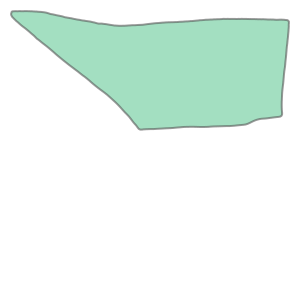

In [8]:
get_polygon(field_bounds_str)

In [9]:
start_point = np.array([23.990487, 50.063754])
diff = np.random.uniform(-0.008000, 0.011000, (1000, 2))/500
diff.min(), diff.max()

(-1.597922245229189e-05, 2.1999957389988245e-05)

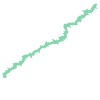

In [10]:
path = [start_point]
for dxy in diff:
    path.append(path[-1] + dxy)
path = np.array(path)
lpath = LineString(path)
lpath

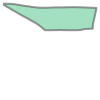

In [11]:
Polygon(get_bounds_from_string(field_bounds_str)[0])

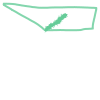

In [12]:
lpath.union(LineString(get_bounds_from_string(field_bounds_str)[0]))

In [13]:
lon, lat = path.T

In [14]:
area_calc = {
    'tool_width' : 8,
    'time' : np.ones(900),
    'lat' : lat[:900],
    'long' : lon[:900],
    'path_distance' : [0,0],
    'field_processed' : [0,0]
}

In [15]:
%%time
calc_dict = update_area_calc(area_calc, field_bounds_str)

CPU times: user 23.9 s, sys: 102 ms, total: 24 s
Wall time: 24 s


In [16]:
dif_calc = {
    'tool_width' : 8,
    'time' : np.ones(1000),
    'lat' : lat,
    'long' : lon,
    'path_distance' : calc_dict['path_distance'],
    'field_processed' : calc_dict['field_processed']
}

In [17]:
%%time
diff_calc = update_area_calc(dif_calc, field_bounds_str)

CPU times: user 6.42 s, sys: 44.4 ms, total: 6.47 s
Wall time: 6.48 s


In [18]:
area_calc = {
    'tool_width' : 8,
    'time' : np.ones(300),
    'lat' : lat[:300],
    'long' : lon[:300],
    'path_distance' : [0,0],
    'field_processed' : [0,0]
}

In [19]:
%%time
calc_dict = update_area_calc(area_calc, field_bounds_str)

CPU times: user 2.25 s, sys: 9.62 ms, total: 2.26 s
Wall time: 2.25 s
